In [ ]:
import sys
import json

from data.loader import DataLoader
from data import preprocessor
import transformer_full
from libs import *
from models.evaluation import find_kappa, plot_results

In [ ]:
# Sets all random seeds for the program (Python, NumPy, and TensorFlow)
keras.utils.set_random_seed(117)
tf.config.experimental.enable_op_determinism()

In [ ]:
tf.__version__

'2.18.0'

# Data loading

In [ ]:
wind_turbine = input("Enter the wind turbine name: ")

In [ ]:
model_name = f"FT_{wind_turbine}"
project_folder = ".."
samples_per_day = 144
MA_window = samples_per_day * 1
MA_window_FPI = samples_per_day * 7

In [ ]:
# Read the wind turbine name from the json file
with open('../wind_turbines.json', 'r') as f:
    wind_turbines_names = json.load(f)

WT_name = wind_turbines_names[wind_turbine]

In [ ]:
years_of_data = [2020, 2021, 2022]
training_dates = pd.date_range(start='2020-06-01', end='2021-01-01', freq='min')
testing_dates = pd.date_range(start='2021-01-01', end='2022-03-01', freq='min')

In [ ]:
features_list = [
    wind_turbine + "_Gear Bearing Temp. Avg.",
    wind_turbine + "_Gear Bearing Temp.B Avg.",
    wind_turbine + "_Gear Bearing Temp.C Avg.",
    wind_turbine + "_Gear Oil Temp. Avg.",
    wind_turbine + "_Gear Oil Temp.Inlet Avg.",
    wind_turbine + "_Rotor RPM Max.",
    wind_turbine + "_Rotor RPM Avg."
]

In [ ]:
columns = [
    'gear_bearing_temp',
    'gear_bearing_temp_b',
    'gear_bearing_temp_c',
    'gear_oil_temp',
    'gear_oil_temp_inlet',
    'rotor_rpm_max',
    'rotor_rpm_avg'
]

In [ ]:
# Load the data
data_loader = DataLoader(
    wind_turbine=wind_turbine,
    years=years_of_data,
    features_list=features_list,
    column_names=columns
)
data = data_loader.load_from_pickle(path=project_folder)

In [ ]:
data = preprocessor.clean_data(data)
data = preprocessor.smooth_data(data, rolling_window=MA_window)
data = preprocessor.remove_outliers(data, threshold=5)
data = preprocessor.feature_selection(data)

## Train-test Split

In [ ]:
# Selecting training and testing data
training_set = data[data['date'].isin(training_dates)]
testing_set = data[data['date'].isin(testing_dates)]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(training_set.iloc[:,1:])

training_set.iloc[:,1:]=scaler.transform(training_set.iloc[:,1:])
testing_set.iloc[:,1:]=scaler.transform(testing_set.iloc[:,1:])

In [ ]:
n_steps = samples_per_day
x_train, y_train = preprocessor.split_sequences(training_set, n_steps)
print(x_train.shape, y_train.shape)

(30673, 144, 5) (30673,)


In [ ]:
x_test, y_test = preprocessor.split_sequences(testing_set, n_steps)
print(x_test.shape, y_test.shape)

(60912, 144, 5) (60912,)


# Model definition and training

In [ ]:
# load the model and prepare for continuing training
model = keras.models.load_model(f'{project_folder}/Models/{pre_trained_model}.keras')

model.compile(loss="mean_squared_error",
    optimizer = keras.optimizers.Adam(learning_rate=0.00001)
)

callbacks = [keras.callbacks.ModelCheckpoint(f"{project_folder}/Models/Checkpoints/FT_{wind_turbine}_{MA_window}_ckpt.keras", save_best_only=True, monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, verbose=1),]

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    #validation_data=(x_val, y_val),
    shuffle=False,
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
)

Epoch 1/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/step - loss: 3.2895e-04 - val_loss: 1.5173e-04
Epoch 2/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - loss: 2.1838e-04 - val_loss: 1.4410e-04
Epoch 3/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 2.1716e-04 - val_loss: 1.7314e-04
Epoch 4/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 2.1436e-04 - val_loss: 1.6203e-04
Epoch 5/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 2.1340e-04 - val_loss: 1.5390e-04
Epoch 6/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 2.1071e-04 - val_loss: 1.7591e-04
Epoch 7/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 2.0871e-04 - val_loss: 1.8383e-04
Epoch 8/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 2.0600e-04 - val_loss: 2.0787e-04
Epoch 9/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 2.0082e-04 - val_loss: 1.7907e-04
Epoch 10/30
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 2.0133e-04 - val_loss: 2.3575e-04
Epoch 11/30
384/384 ━━━━━━━━━━━━━━━━━━━

In [ ]:
model.save(f'{project_folder}/Models/FT_{wind_turbine}_{MA_window}.keras')
history_df = pd.DataFrame(history.history)
history_df.to_csv(f'{project_folder}/Training_history/FT_{wind_turbine}_{MA_window}_history.csv', index=False)

loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

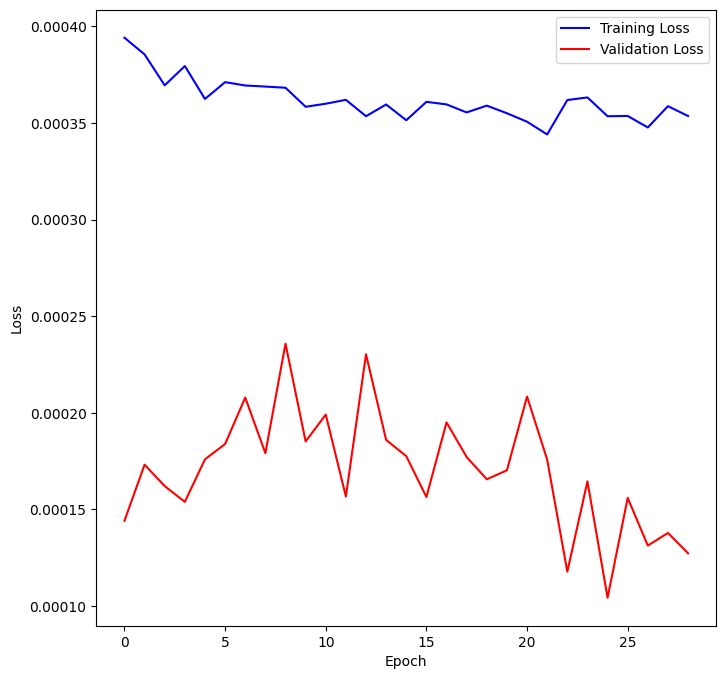

In [ ]:
fig,ax = plt.subplots(figsize=(8,8))
sns.lineplot(data=loss, ax = ax, color="b", label='Training Loss')
sns.lineplot(data=val_loss, ax = ax, color="r", label='Validation Loss')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

# save plot as image
plt.savefig(f'{project_folder}/Training_plots/FT_{wind_turbine}_{MA_window}_loss.png')

# Model evaluation

In [ ]:
y_train_pred = model.predict(x_train)

959/959 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step


In [ ]:
y_pred = model.predict(x_test)

1904/1904 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step


In [ ]:
y_train = y_train.reshape(-1)
y_train_pred = y_train_pred.reshape(-1)

In [ ]:
# There is a shift of n_steps between the predictions and the true values
n_steps = 2

In [ ]:
training_dates = data[data['date'].isin(training_dates)].date
testing_dates = data[data['date'].isin(testing_dates)].date

In [ ]:
train_results = pd.DataFrame({'date':training_dates[samples_per_day + n_steps:],
                              'Real':y_train[:-1*n_steps],
                              'Predicted': y_train_pred[n_steps:]})
train_results

,date,Real,Predicted
21603,2020-06-02 00:20:00,0.420092,0.425911
21604,2020-06-02 00:30:00,0.420398,0.426169
21605,2020-06-02 00:40:00,0.421087,0.426514
21606,2020-06-02 00:50:00,0.422082,0.426901
21607,2020-06-02 01:00:00,0.423153,0.427347
...,...,...,...
52269,2020-12-31 23:20:00,0.472943,0.477604
52270,2020-12-31 23:30:00,0.472101,0.476543
52271,2020-12-31 23:40:00,0.471106,0.475513
52272,2020-12-31 23:50:00,0.470264,0.474515


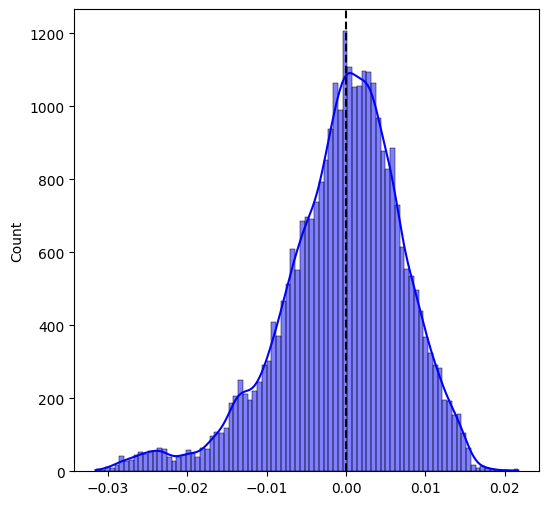

In [ ]:
# Checking for bias in the residuals distribution plot
residuals = train_results['Real'] - train_results['Predicted']

fig,ax = plt.subplots(figsize=(6,6))
sns.histplot(residuals, kde=True, color='blue', ax=ax)
plt.axvline(x=0, color='black', linestyle='--')

Biased mean:  -0.00046433190684020054


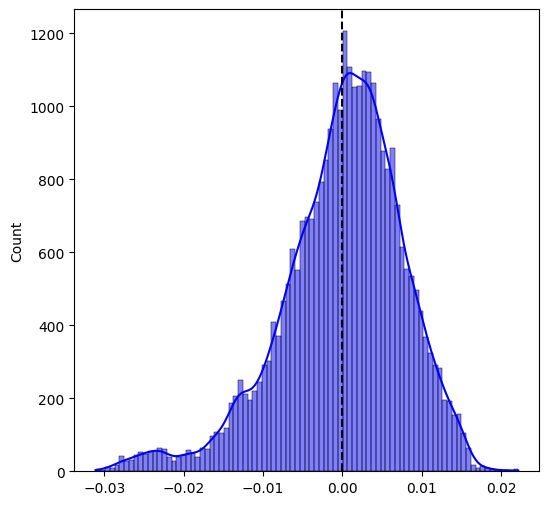

In [ ]:
biased_mean = np.mean(train_results['Real'] - train_results['Predicted'])
print("Biased mean: ", biased_mean)

train_results['Predicted'] += biased_mean

# Plotting the distribution of the residuals again
residuals = train_results['Real'] - train_results['Predicted']

fig,ax = plt.subplots(figsize=(6,6))
sns.histplot(residuals, kde=True, color='blue', ax=ax)
plt.axvline(x=0, color='black', linestyle='--')

In [ ]:
train_results['Residual'] = abs(train_results.Real - train_results.Predicted)

In [ ]:
window = samples_per_day * 7   #Averaged per week
#averaged_error = train_results.Residual.rolling(window = window).mean()[window-1:]
train_results['Residual'] = train_results['Residual'].ewm(span=window).mean()

<Axes: xlabel='Residual', ylabel='Count'>

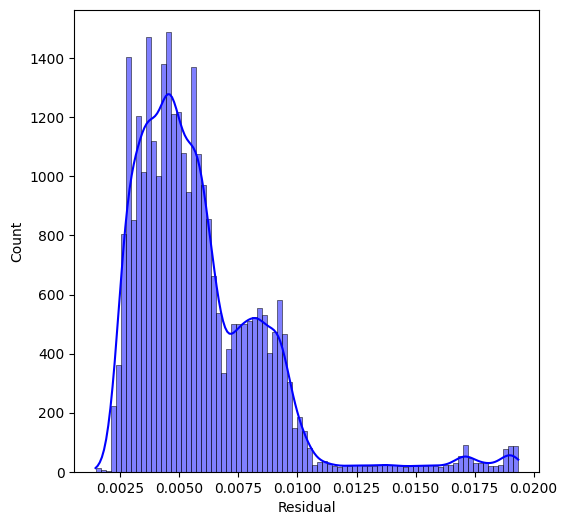

In [ ]:
# Plotting the residuals distribution
fig, ax = plt.subplots(figsize=(6,6))
sns.histplot(train_results['Residual'], kde=True, color='blue', ax=ax)

### Threshold selection

In [ ]:
# Calculating median and std for threshold definition, as residual distribution is right skewed
median_error = train_results.Residual.median()
std_error = train_results.Residual.std()

In [ ]:
selected_kappa = find_kappa(train_results, median_error, std_error)

Number of outliers found for threshold k=3.0: 888
Number of outliers found for threshold k=3.2: 830
Number of outliers found for threshold k=3.4: 782
Number of outliers found for threshold k=3.6: 724
Number of outliers found for threshold k=3.8: 670
Number of outliers found for threshold k=4.0: 608
Number of outliers found for threshold k=4.2: 420
Number of outliers found for threshold k=4.4: 341
Number of outliers found for threshold k=4.6: 275
Number of outliers found for threshold k=4.8: 95
Number of outliers found for threshold k=5.0: 0
Optimal kappa value found: 5.0


In [ ]:
threshold = median_error + selected_kappa*std_error

## Test set

In [ ]:
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

In [ ]:
test_result = pd.DataFrame({'date':testing_dates[samples_per_day + n_steps:],
                          'Real':y_test[:-1*n_steps],
                          'Predicted': y_pred[n_steps:]})
test_result

,date,Real,Predicted
52419,2021-01-02 00:20:00,0.441791,0.444505
52420,2021-01-02 00:30:00,0.442403,0.445535
52421,2021-01-02 00:40:00,0.442863,0.446512
52422,2021-01-02 00:50:00,0.443169,0.447447
52423,2021-01-02 01:00:00,0.443398,0.448330
...,...,...,...
113324,2022-02-28 23:10:00,0.819135,0.812265
113325,2022-02-28 23:20:00,0.821202,0.814038
113326,2022-02-28 23:30:00,0.823421,0.815874
113327,2022-02-28 23:40:00,0.825641,0.817764


In [ ]:
score = np.sqrt(metrics.mean_squared_error(test_result.Real,test_result.Predicted))
print("Score RMSE: {}".format(score))

Score RMSE: 0.007739375984646669


In [ ]:
test_result['Predicted'] += biased_mean

In [ ]:
test_result['Residual'] = abs(test_result['Real'] - test_result['Predicted'])

In [ ]:
window = samples_per_day * 7  #Averaged per week
#averaged_error = test_result.Residual.rolling(window = window).mean()[window-1:]
test_result['Residual'] = test_result['Residual'].ewm(span=window).mean()

## Checking alarm activations

In [ ]:
window_size = samples_per_day * 7
exceedances = test_result['Residual'].rolling(window=window_size).apply(lambda x: all(x > threshold), raw=True)
test_result['Alarm'] = exceedances

In [ ]:
test_result.loc[test_result['Alarm'] == 1.0]

,date,Real,Predicted,Residual,Alarm


In [ ]:
if test_result.loc[test_result['Alarm'] == 1.0].shape[0] == 0:
    print("No alarm was triggered")
else:
    alarm_date = str(test_result.loc[test_result['Alarm'] == 1.0]['date'].iloc[0])
    print(f'Alarm triggered at {alarm_date}')

No alarm was triggered


In [ ]:
alarm_df = pd.DataFrame({
    'date': data[data['date'].isin(pd.date_range(start='2020-06-01', end='2022-03-01', freq='min'))].date,
})

In [ ]:
alarm_df = pd.merge(alarm_df, test_result[['date', 'Alarm']], on='date', how='left')
alarm_df['Alarm'] = alarm_df['Alarm'].fillna(0)

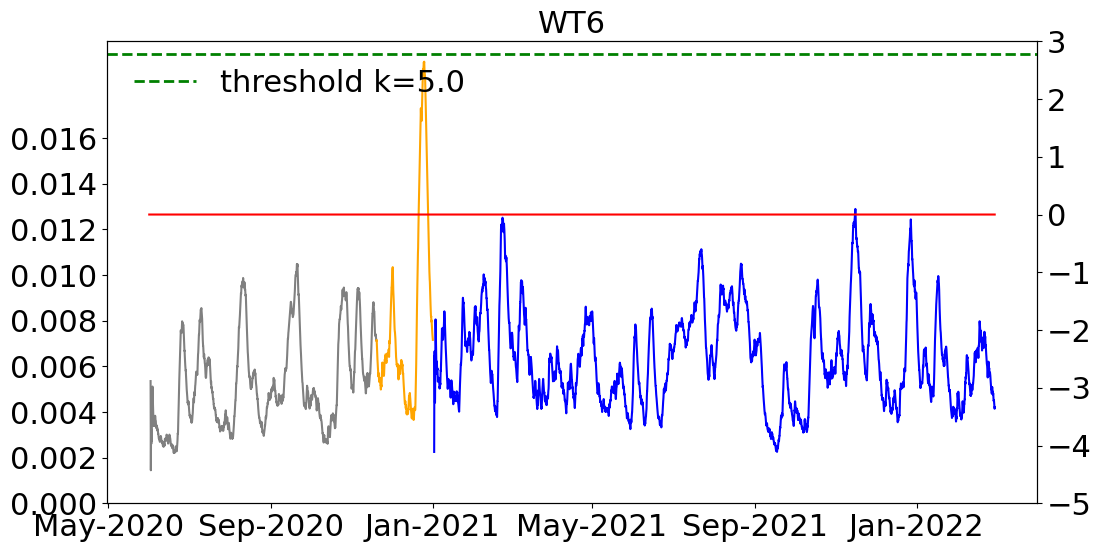

In [ ]:
plot_results(
    train_results = train_results,
    test_result = test_result,
    alarm_df = alarm_df,
    training_split = 0.8,
    project_folder = project_folder,
    wind_turbine = wind_turbine,
    threshold = threshold,
    selected_kappa = selected_kappa,
    WT_name = WT_name,
    MA_window = MA_window,
    alarm_mode = 'dynamic'
)